In [1]:
import numpy as np
from qick import *
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
soc = QickSoc(bitfile='/home/xilinx/jupyter_notebooks/qick/qick_demos/custom/bitstreams/base_MTS_14.bit')
soccfg = soc
print(soccfg)


QICK configuration:

	Board: ZCU216

	Software version: 0.2.267
	Firmware timestamp: Tue Oct  1 16:49:08 2024

	Global clocks (MHz): tProcessor 350.000, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (10.667 us)
		fs=6144.000 MHz, fabric=384.000 MHz, 32-bit DDS, range=6144.000 MHz
		DAC tile 0, blk 0 is 0_228, on JHC1
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (10.667 us)
		fs=6144.000 MHz, fabric=384.000 MHz, 32-bit DDS, range=6144.000 MHz
		DAC tile 0, blk 1 is 1_228, on JHC2
	2:	axis_signal_gen_v6 - envelope memory 65536 samples (10.667 us)
		fs=6144.000 MHz, fabric=384.000 MHz, 32-bit DDS, range=6144.000 MHz
		DAC tile 1, blk 3 is 3_229, on JHC2
	3:	axis_signal_gen_v6 - envelope memory 65536 samples (10.667 us)
		fs=6144.000 MHz, fabric=384.000 MHz, 32-bit DDS, range=6144.000 MHz
		DAC tile 1, blk 0 is 0_229, on JHC1
	4:	axis_signal_gen_v6 - envelope memory 65536 samples (10.667 us)
		fs=6144.000 MHz, fabric=3

In [3]:
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/qick/qick_demos/custom/drivers')

from TIDAC80508 import TIDAC80508
tidac = TIDAC80508()

from HMC7044 import HMC7044
hmc = HMC7044()

In [4]:
soccfg.usp_rf_data_converter_0.mts_dac_config.RefTile = 2
soccfg.usp_rf_data_converter_0.mts_dac_config.Tiles = 0b0011
soccfg.usp_rf_data_converter_0.mts_dac_config.SysRef_Enable = 1
soccfg.usp_rf_data_converter_0.mts_dac_config.Target_Latency = -1
soccfg.usp_rf_data_converter_0.mts_dac()

In [5]:
### SET POWER FOR DACs ###
dac_2280 = soccfg.usp_rf_data_converter_0.dac_tiles[0].blocks[0]
dac_2281 = soccfg.usp_rf_data_converter_0.dac_tiles[0].blocks[1]
dac_2290 = soccfg.usp_rf_data_converter_0.dac_tiles[1].blocks[0]
dac_2291 = soccfg.usp_rf_data_converter_0.dac_tiles[1].blocks[1]
dac_2292 = soccfg.usp_rf_data_converter_0.dac_tiles[1].blocks[2]
dac_2293 = soccfg.usp_rf_data_converter_0.dac_tiles[1].blocks[3]
dac_2300 = soccfg.usp_rf_data_converter_0.dac_tiles[2].blocks[0]
dac_2280.SetDACVOP(40000) # POWER FOR RF FLUX DAC (mA)
dac_2281.SetDACVOP(40000) # POWER FOR RF FLUX DAC (mA)
dac_2290.SetDACVOP(30000) # POWER FOR DRIVE DAC (mA)
dac_2291.SetDACVOP(30000) # POWER FOR DRIVE DAC (mA)
dac_2292.SetDACVOP(30000) # POWER FOR DRIVE DAC (mA)
dac_2293.SetDACVOP(30000) # POWER FOR DRIVE DAC (mA)
dac_2300.SetDACVOP(5000) # POWER FOR READOUT DAC (mA)

In [6]:
DRIVE       = [3,4,5,2]
FLUX        = [0,1]
PROBE_CH    = 6
FEEDBACK_CH = [0,1,2,3] #ADC
MAX_GAIN    = 32766  

In [7]:
class MuxReadoutTest_MTS(AveragerProgram):    
    def ns2cycles(self, ns, gen_ch=None, ro_ch=None):
        return self.us2cycles(ns/1000, gen_ch=gen_ch, ro_ch=ro_ch)
    
    def initialize(self):
        cfg=self.cfg
        for iCh, ch in enumerate(self.cfg['ro_ch']):
            self.declare_readout(ch = ch, freq = self.cfg['ro_freqs'][iCh], length = self.ns2cycles(self.cfg['ro_length'], ro_ch=self.cfg['ro_ch'][iCh]), gen_ch = self.cfg['gen_ch'])        
        self.declare_gen(ch=self.cfg["gen_ch"], nqz=2, mux_freqs = self.cfg['pulse_freqs'], mux_gains = self.cfg['pulse_gains'], mux_phases = self.cfg['pulse_phases'], ro_ch = self.cfg['ro_ch'][1])
        self.set_pulse_registers(ch = self.cfg['gen_ch'], style = 'const', length=self.ns2cycles(self.cfg['pulse_length'], gen_ch=self.cfg['gen_ch']), mask=[0,1,2,3])
        self.synci(200)
    
    def body(self):
        cfg = self.cfg
        ro_pulse_start = self.ns2cycles(cfg["ro_pulse_start"])
        self.measure(pulse_ch = self.cfg['gen_ch'], adcs = self.ro_chs, adc_trig_offset = self.ns2cycles(self.cfg['ro_offset']), t=ro_pulse_start)

In [8]:
config={"ro_ch"          : FEEDBACK_CH,
        "ro_length"      : 3000,
        "ro_freqs"       : [7432.754, 7511.699, 7549.031, 7584.315],
        "ro_offset"      : 710, #TOF
        "ro_pulse_start" : 0,
        
        "gen_ch"         : PROBE_CH,     
        "pulse_length"   : 3000,
        "pulse_freqs"    : [7432.754, 7511.699, 7549.031, 7584.315],
        "pulse_gains"    : [1,1,1,1],
        "pulse_phases"   : [0,0,0,0],
        
        "reps"           : 1,
       }

  0%|          | 0/1 [00:00<?, ?it/s]

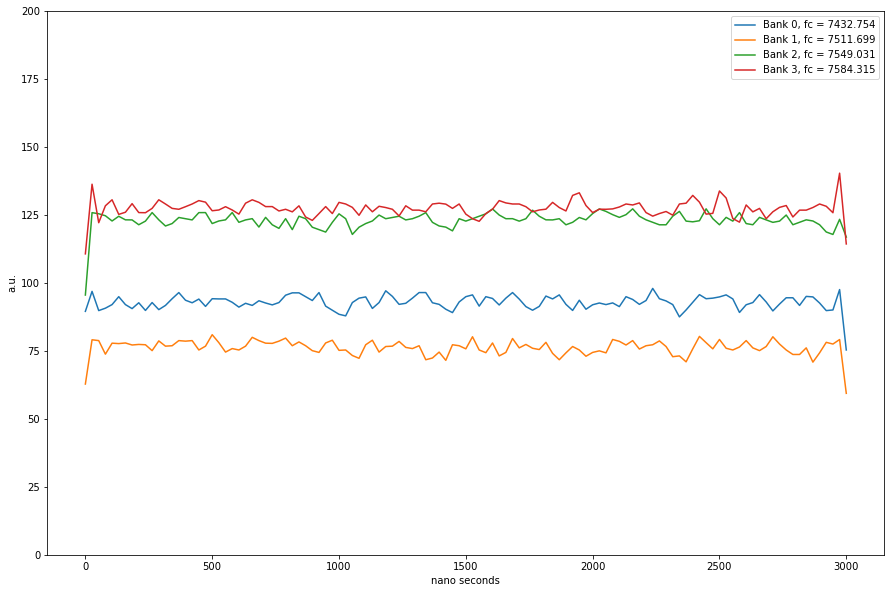

In [9]:
#############################################
### PLOT PROGRAM OF AveragerProgram CLASS ###
#############################################

prog = MuxReadoutTest_MTS(soccfg, config)
iq_list = prog.acquire_decimated(soc, start_src="internal", load_pulses=True)
t = np.linspace(0, config["ro_length"], len(iq_list[0][0]))
plt.figure(figsize=(15,10))
for ii, iq in enumerate(iq_list):
    plt.plot(t, np.abs(iq[0]+1j*iq[1]), label="Bank {}, fc = {}".format(ii, config["ro_freqs"][ii]))
plt.ylabel("a.u.")
plt.ylim(0, 200)
plt.xlabel("nano seconds")
plt.legend();